In [1]:
import numpy as np
import geopandas as gpd
from shapely.geometry import Point
import pandas as pd
import re as re
import os
import copy
import statsmodels.formula.api as sm
import pymc3 as pm
import matplotlib.pyplot as plt

WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
C:\Users\Yurii\Anaconda3\lib\site-packages\theano\configdefaults.py:560: UserWarning: DeprecationWarning: there is no c++ compiler.This is deprecated and with Theano 0.11 a c++ compiler will be mandatory
  warnings.warn("DeprecationWarning: there is no c++ compiler."
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
conflict = pd.read_csv('Data\\conflict_data\\DRC_2.csv', header = 0, index_col = 0)

aid = pd.read_csv('Data\\aid_data\\data\\level_1a.csv')
aid = aid.dropna(subset=['latitude', 'longitude', 'transactions_start_year']) # drop those entries that don't have coordinates and start year to them
#aid = aid.drop(aid[aid['transactions_start_year'] == ' '].index) # some projects don't have start year, so we drop those rows
aid = aid.drop(aid[aid['even_split_commitments'].isnull()].index) # some projects don't have info on commitments, so we drop those rows
aid['transactions_start_year'] = pd.to_numeric(aid['transactions_start_year'])

worker_deaths = pd.read_csv('Data\\security_incidents.csv', encoding = "ISO-8859-1")

provinces = gpd.read_file('Data\\gadm36_COD_shp/gadm36_COD_1.shp')

In [3]:
geometry = [Point(xy) for xy in zip(conflict.longitude, conflict.latitude)]
gconflict = gpd.GeoDataFrame(conflict, crs = {'init': 'epsg:4326'}, geometry = geometry)

geometry = [Point(xy) for xy in zip(aid.longitude, aid.latitude)]
gaid = gpd.GeoDataFrame(aid, crs = {'init': 'epsg:4326'}, geometry = geometry)

geometry = [Point(xy) for xy in zip(worker_deaths.Longitude, worker_deaths.Latitude)]
g_w_d = gpd.GeoDataFrame(worker_deaths, crs = {'init': 'epsg:4326'}, geometry = geometry) # g_w_d = gworker_deaths


gconflict = gpd.sjoin(gconflict, provinces, how="inner")
gaid = gpd.sjoin(gaid, provinces, how="inner")
g_w_d = gpd.sjoin(g_w_d, provinces, how="inner")


In [4]:
# calculate the number of rows there column_name has more than one entry, separated by "|". We use this for donors and aid focus. 
def calc_multiples(df, column_name):
    s = 0
    l = []
    for index, row in df.iterrows():
        entries = row[column_name].split("|")
        if len(entries) > 1:
            s += 1
            l.append(index)
    return s#, l

# split those rows that have more than one entry in a certain column name.
# We create a new row for each of the multiple entries (other entries being the same)
# and delete the original multiple entry row. 
def split_rows(data, column_name):
    df = copy.deepcopy(data)
    temp = pd.DataFrame()
    for index, row in df.iterrows():
        entries = row[column_name].split("|")
        if len(entries) > 1:
            for entry in entries:
                temp_row = row
                temp_row[column_name] = entry
                temp = temp.append(temp_row)
            df.drop(index, inplace = True)
            
    return df.append(temp)

# split the rows(projects) that have more than one donor per project
gaid = split_rows(gaid, 'donors')
gaid = split_rows(gaid, 'ad_sector_names')

In [5]:
if not os.path.exists('measures_indices'):
    os.makedirs('measures_indices')
    
# how many projects there are per donor and their share in the total, save in a csv file  
total = gaid['donors'].value_counts() # total N of projects per donor
share = gaid['donors'].value_counts() / gaid.shape[0] # calculate share of the projects per donor in total N of projects
pd.concat([total, share], axis = 1).to_csv('measures_indices\\N_projects_per_donor.csv')

# what share of projects per donor have multiple focus sectors (e.g. General environmental protection|Transport and storage)
multiple_focus_share = (gaid.groupby('donors').apply(calc_multiples, 'ad_sector_names') / gaid['donors'].value_counts())
multiple_focus_share.to_csv('measures_indices\\project_multiple_sectors.csv')

# share of each project focus in the total number of projects per donor. We use this to calculate variablity of project focus for a donor
focus_share = (gaid.groupby(['donors', 'ad_sector_names']).size() / gaid.groupby(['donors']).size())
focus_share.to_csv('measures_indices\\donor_sector_share.csv')

In [6]:
# Func calculates the coefficient of unalikeability (as defined by Kader 2007) of every sublcass of first_group variable by topic_name
# E.g. unalikeability of project location for each aid donor -> calc_unalikeability(gaid, 'donors', 'ad_sector_names')

def calc_unalikeability(data, first_group, topic_name):
    
    # prepare data: group by first_group and topic_name, and divide by the size of the respective group
    # thus we obtain the share that each topic_name has in the respective first_group
    
    d = (data.groupby([first_group, topic_name]).size() / gaid.groupby([first_group]).size())
    
    # here we get the keys for the first level grouping. So, the unique values of first group column
    keys = []
    for i in d.index:
        keys.append(i[0])
    keys = set(keys)
    
    # here we calculate the actual coefficient
    # for every value of first_group we calculate its coefficient:
    # coefficient is defined as 1 - SUM_i(p_i^2), where p_i is the share of the ith subgroup in the total group. 
    
    coefs = {}
    for key in keys:
        s = 0
        for subgroup in d[key]:
            s += subgroup ** 2
        coef = 1 - s
        coefs[key] = coef
    return pd.Series(coefs)


# calculates the variablity of topic_name (e.g. total commitments of money) for every member of first_group
def calc_var(data, first_group, topic_name):
    d = data.groupby(first_group)
    
    def var(d):
        d = d[topic_name]
        d = (d - min(d)) / (max(d) - min(d))
        
        if np.isnan(np.var(d)):
            return 0
        
        return np.var(d)
    
    return d.apply(var)

In [7]:
adaptability_by_focus = calc_unalikeability(gaid, 'donors', 'ad_sector_names')
adaptability_by_location =calc_unalikeability(gaid, 'donors', 'NAME_1')
adaptability_by_start_year = calc_unalikeability(gaid, 'donors', 'transactions_start_year')
adaptability_by_commitment = calc_var(gaid, 'donors', 'total_commitments')
composite_adaptability = adaptability_by_commitment + adaptability_by_start_year + adaptability_by_location + adaptability_by_focus
#pd.DataFrame.from_dict(adaptability_by_focus, orient = 'index').to_csv('measures_indices\\adaptability_by_focus.csv')
#pd.DataFrame.from_dict(adaptability_by_location, orient = 'index').to_csv('measures_indices\\adaptability_by_location.csv')
#pd.DataFrame.from_dict(adaptability_by_start_year, orient = 'index').to_csv('measures_indices\\adaptability_by_start_year.csv')
#adaptability_by_commitment.to_csv('measures_indices\\adaptability_by_commitments.csv')
#(composite_adaptability).to_csv('measures_indices\\composite_adaptability.csv')

In [8]:
# Divide donors into 2 groups: higly adaptable and not higly adaptable, the division line is the median. 
median = composite_adaptability.median()
high_adaptability = composite_adaptability[composite_adaptability >= median]
low_adaptability = composite_adaptability[composite_adaptability < median]

In [47]:
# Compute the year, ADM1 pairs of events when aid workers were killed. 
# Then, we can assume that these are unreceptive year, region pairs.
# However, we can also divide this into 2 subgroups: more than average (or median) casualties vs less than average (or median) casualties
worker_deaths_grouped = g_w_d.groupby(['Year', 'NAME_1'])['Total affected'].sum()
worker_deaths_grouped.to_csv('measures_indices\\year_location_pairs.csv')

# The idea is that low_receptivity is depcited by a lot of worker deaths
# high receptivity is depicted by a lesser number of worker deaths

#low_receptivity = worker_deaths_grouped > worker_deaths_grouped.describe()['mean']
#high_receptivity = worker_deaths_grouped < worker_deaths_grouped.describe()['mean']

low_receptivity = worker_deaths_grouped > 0
high_receptivity = worker_deaths_grouped == 0

In [48]:
# custom function to check whether a tuple is included in an array of tuples (for some reason, basic function did not work)
def check_in (tupl, array):
    for element in array:
        if (tupl[0] == element[0]) & (tupl[1] == element[1]):
            return True

# select those row numbers (indices) of gaid dataframe that represent projects that started in the same year/adm1 combination
# as highly receptive ones
low_receptive_indices = []
for index, row in gaid.iterrows():
    tupl = (int(row['transactions_start_year']), row['NAME_1'])
    if check_in(tupl, worker_deaths_grouped[low_receptivity].index.values):
        low_receptive_indices.append(index)

        
# select projects that are created in higly receptive and low receptive year/adm1 combinations 

low_receptive = gaid.iloc[low_receptive_indices]
highly_receptive = gaid.loc[~gaid.index.isin(low_receptive_indices)]

#low_receptive = gaid.loc[~gaid.index.isin(high_receptive_indices)]
#highly_receptive = gaid.iloc[high_receptive_indices]

In [49]:
# High receptivity + high adaptability indices
high_receptivity_high_adaptability = highly_receptive[highly_receptive['donors'].isin(high_adaptability.index)]
high_receptivity_low_adaptability = highly_receptive[highly_receptive['donors'].isin(low_adaptability.index)]

low_receptivity_high_adaptability = low_receptive[low_receptive['donors'].isin(high_adaptability.index)]
low_receptivity_low_adaptability = low_receptive[low_receptive['donors'].isin(low_adaptability.index)]

In [51]:
region_year_casualties = gconflict[['year', 'NAME_1', 'best_est']].groupby(['NAME_1', 'year']).sum()
region_year_aid = gaid[['transactions_start_year', 'NAME_1', 'even_split_commitments']].groupby(['NAME_1', 'transactions_start_year']).sum()

In [52]:
def add_lag(df, column_name, new_name):
    output = pd.DataFrame()
    df[new_name] = df.groupby(level = 0)[column_name].shift(1)
    by_country = df.groupby(level = 0)
    for name, group in by_country:
        country = group.reset_index()
        last_row = country.iloc[-1, :]
        if new_name == 'lagged_commitments':
            temp = pd.Series({'NAME_1': last_row['NAME_1'],
                      'transactions_start_year': last_row['transactions_start_year'] + 1, 
                      'even_split_commitments': float('nan'),
                      'lagged_commitments' : last_row['even_split_commitments']})
        if new_name == 'lagged_casualties':
            temp = pd.Series({'NAME_1': last_row['NAME_1'],
                      'year': last_row['year'] + 1, 
                      'best_est': float('nan'),
                      'lagged_casualties' : last_row['best_est']})
        country = country.append(temp, ignore_index = True)
        output = output.append(country)
    return output

In [53]:
# add the lag variable (for a (district, year) pair (d, t) , we are looking at commitments on (d, t-1). This action also resets hierachical index
region_year_aid = add_lag(region_year_aid, 'even_split_commitments', 'lagged_commitments')

# rename the column regarding the start year so that it corresponds to the name in casualties dataset
region_year_aid = region_year_aid.rename(columns = {'even_split_commitments': 'commitments', 'transactions_start_year': 'year'})

# reset the hierachical index, so that the dataframe obtain the same structure
region_year_casualties = add_lag(region_year_casualties, 'best_est', 'lagged_casualties')

In [89]:
region_year_aid['commitments_difference'] = region_year_aid['commitments'] - region_year_aid['lagged_commitments']
region_year_aid['log_commitments'] = np.log(region_year_aid['commitments'] )
region_year_aid['log_lagged_commitments'] = np.log(region_year_aid['lagged_commitments'] )
region_year_aid['log_difference'] = np.log(region_year_aid['commitments_difference'] )
region_year_aid['difference_of_logs'] = region_year_aid['log_commitments'] - region_year_aid['log_lagged_commitments']

region_year_casualties['casulaties_difference'] = region_year_casualties['best_est'] - region_year_casualties['lagged_casualties']
region_year_casualties['casulaties_log'] = np.log(region_year_casualties['best_est'])
#region_year_casualties['casulaties_log'] = np.log(region_year_casualties['best_est'])
region_year_casualties['casulaties_standardized'] = (region_year_casualties['best_est'] - np.mean(region_year_casualties['best_est'])) / np.var(region_year_casualties['best_est'])
region_year_casualties['lagged_casualties_standardized'] = (region_year_casualties['lagged_casualties'] - np.mean(region_year_casualties['lagged_casualties'])) / np.var(region_year_casualties['lagged_casualties'])

In [91]:
aid_and_conflict = pd.merge(region_year_aid, region_year_casualties, on = ['NAME_1', 'year'])

In [65]:
aid_and_conflict

,NAME_1,year,commitments,lagged_commitments,commitments_difference,log_commitments,log_lagged_commitments,log_difference,difference_of_logs,best_est,lagged_casualties,casulaties_difference,casulaties_log,casulaties_standardized
0,Bas-Uélé,1999,1.525185e+07,NaN,NaN,16.540211,NaN,NaN,NaN,100.0,217.0,-117.0,4.605170,-0.000118
1,Bas-Uélé,2006,1.216301e+08,1.525185e+07,1.063782e+08,18.616495,16.540211,18.482512,2.076284,1.0,22.0,-21.0,0.000000,-0.000155
2,Bas-Uélé,2008,6.907895e+07,1.637124e+07,5.270771e+07,18.050761,16.611037,17.780272,1.439724,69.0,1.0,68.0,4.234107,-0.000130
3,Bas-Uélé,2009,3.422347e+07,6.907895e+07,-3.485548e+07,17.348422,18.050761,NaN,-0.702338,230.0,69.0,161.0,5.438079,-0.000071
4,Bas-Uélé,2010,2.399350e+07,3.422347e+07,-1.022997e+07,16.993294,17.348422,NaN,-0.355129,116.0,230.0,-114.0,4.753590,-0.000113
5,Bas-Uélé,2011,2.425031e+07,2.399350e+07,2.568067e+05,17.003940,16.993294,12.456079,0.010646,49.0,116.0,-67.0,3.891820,-0.000137
6,Bas-Uélé,2012,4.476538e+07,2.425031e+07,2.051507e+07,17.616946,17.003940,16.836670,0.613006,1.0,49.0,-48.0,0.000000,-0.000155
7,Bas-Uélé,2013,1.330901e+07,4.476538e+07,-3.145637e+07,16.403952,17.616946,NaN,-1.212994,12.0,1.0,11.0,2.484907,-0.000151
8,Bas-Uélé,2014,NaN,1.330901e+07,NaN,NaN,16.403952,NaN,NaN,26.0,12.0,14.0,3.258097,-0.000145
9,Haut-Katanga,2008,3.158999e+07,4.207627e+07,-1.048628e+07,17.268351,17.554994,NaN,-0.286644,1.0,3.0,-2.0,0.000000,-0.000155


In [108]:
result = sm.ols(formula = 'casulaties_standardized ~ lagged_casualties_standardized + log_lagged_commitments', data = aid_and_conflict).fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                              
===================================================================================
Dep. Variable:     casulaties_standardized   R-squared:                       0.219
Model:                                 OLS   Adj. R-squared:                  0.196
Method:                      Least Squares   F-statistic:                     9.396
Date:                     Sun, 08 Jul 2018   Prob (F-statistic):           0.000253
Time:                             18:53:55   Log-Likelihood:                 519.56
No. Observations:                       70   AIC:                            -1033.
Df Residuals:                           67   BIC:                            -1026.
Df Model:                                2                                         
Covariance Type:                 nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept                         -0.0003      0.000     -1.604      0.113      -0.001    7.96e-05
lagged_casualties_standardized     0.4288      0.110      3.911      0.000       0.210       0.648
log_lagged_commitments          1.638e-05    1.2e-05      1.370      0.175   -7.49e-06    4.03e-05
==============================================================================
Omnibus:                       76.182   Durbin-Watson:                   2.035
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              750.060
Skew:                           3.167   Prob(JB):                    1.34e-163
Kurtosis:                      17.732   Cond. No.                     1.05e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.05e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [62]:
four_groups = {'HR_HA': high_receptivity_high_adaptability,
               'HR_LA':high_receptivity_low_adaptability,
               'LR_HA': low_receptivity_high_adaptability,
               'LR_LA': low_receptivity_low_adaptability}


def estimate_relationship(aid_group):
    region_year_aid = aid_group[['transactions_start_year', 'NAME_1', 'even_split_commitments']].groupby(['NAME_1', 'transactions_start_year']).sum()

    region_year_aid = add_lag(region_year_aid, 'even_split_commitments', 'lagged_commitments')

    region_year_aid = region_year_aid.rename(columns = {'even_split_commitments': 'commitments', 'transactions_start_year': 'year'})

    region_year_aid['commitments_difference'] = region_year_aid['commitments'] - region_year_aid['lagged_commitments']
    region_year_aid['log_commitments'] = np.log(region_year_aid['commitments'] )
    region_year_aid['log_lagged_commitments'] = np.log(region_year_aid['lagged_commitments'] )
    region_year_aid['log_difference'] = np.log(region_year_aid['commitments_difference'] )
    region_year_aid['difference_of_logs'] = region_year_aid['log_commitments'] - region_year_aid['log_lagged_commitments']

    aid_and_conflict = pd.merge(region_year_aid, region_year_casualties, on = ['NAME_1', 'year'])

    result = sm.ols(formula = 'casulaties_standardized ~ difference_of_logs', data = aid_and_conflict).fit()
    print(result.summary())
    



for key, value in four_groups.items():
    print('CURRENT GROUP ', key)
    estimate_relationship(value)

CURRENT GROUP  HR_HA
                               OLS Regression Results                              
Dep. Variable:     casulaties_standardized   R-squared:                       0.001
Model:                                 OLS   Adj. R-squared:                 -0.022
Method:                      Least Squares   F-statistic:                   0.03738
Date:                     Sun, 08 Jul 2018   Prob (F-statistic):              0.848
Time:                             16:23:33   Log-Likelihood:                 367.65
No. Observations:                       46   AIC:                            -731.3
Df Residuals:                           44   BIC:                            -727.6
Df Model:                                1                                         
Covariance Type:                 nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------

C:\Users\Yurii\Anaconda3\lib\site-packages\scipy\stats\stats.py:1334: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  "anyway, n=%i" % int(n))


                               OLS Regression Results                              
Dep. Variable:     casulaties_standardized   R-squared:                       0.044
Model:                                 OLS   Adj. R-squared:                 -0.051
Method:                      Least Squares   F-statistic:                    0.4648
Date:                     Sun, 08 Jul 2018   Prob (F-statistic):              0.511
Time:                             16:23:33   Log-Likelihood:                 107.86
No. Observations:                       12   AIC:                            -211.7
Df Residuals:                           10   BIC:                            -210.7
Df Model:                                1                                         
Covariance Type:                 nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------

C:\Users\Yurii\Anaconda3\lib\site-packages\statsmodels\stats\stattools.py:72: ValueWarning: omni_normtest is not valid with less than 8 observations; 6 samples were given.
  "samples were given." % int(n), ValueWarning)


                               OLS Regression Results                              
Dep. Variable:     casulaties_standardized   R-squared:                       0.000
Model:                                 OLS   Adj. R-squared:                 -0.249
Method:                      Least Squares   F-statistic:                  0.001905
Date:                     Sun, 08 Jul 2018   Prob (F-statistic):              0.967
Time:                             16:23:34   Log-Likelihood:                 42.147
No. Observations:                        6   AIC:                            -80.29
Df Residuals:                            4   BIC:                            -80.71
Df Model:                                1                                         
Covariance Type:                 nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------

In [95]:
import pymc3 as pm
formula = 'casulaties_standardized ~ lagged_casualties_standardized + log_lagged_commitments'

with pm.Model() as normal_model:
    
    # The prior for the data likelihood is a Normal Distribution
    family = pm.glm.families.Normal()
    
    # Creating the model requires a formula and data (and optionally a family)
    pm.GLM.from_formula(formula, data = aid_and_conflict, family = family)
    
    # Perform Markov Chain Monte Carlo sampling letting PyMC3 choose the algorithm
    normal_trace = pm.sample(draws=2000, chains = 2, tune = 1500, njobs=-1)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sd_log__, log_lagged_commitments, lagged_casualties_standardized, Intercept]
  6%|█████                                                                          | 224/3500 [01:57<28:38,  1.91it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


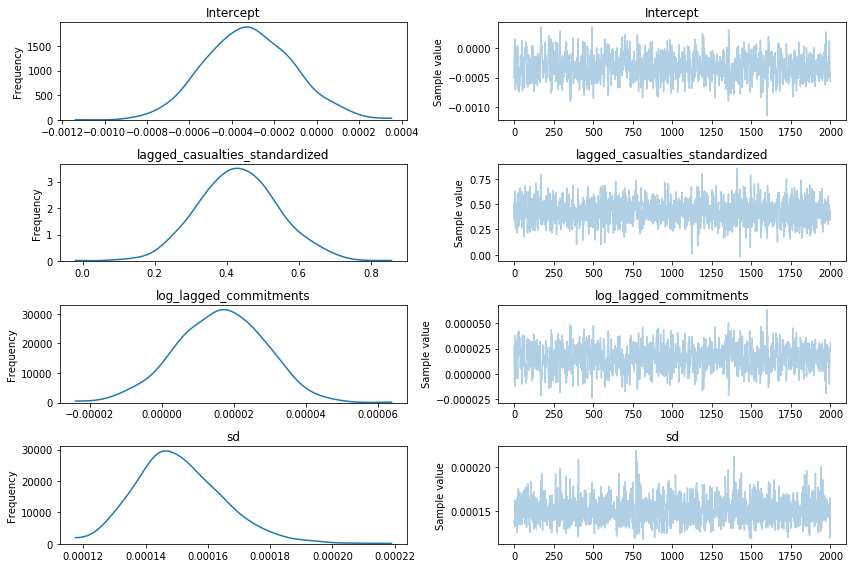

In [97]:
pm.traceplot(normal_trace)
plt.show()

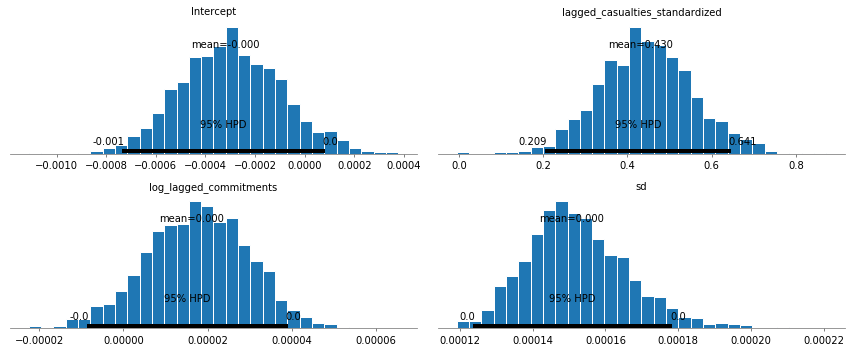

In [98]:
pm.plot_posterior(normal_trace)
plt.show()

In [99]:
pm.summary(normal_trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
Intercept,-0.000322,0.000204,6.849001e-06,-0.000728,0.000072
lagged_casualties_standardized,0.430366,0.111869,2.697830e-03,0.208756,0.640534
log_lagged_commitments,0.000016,0.000012,4.005996e-07,-0.000008,0.000039
sd,0.000151,0.000014,3.882337e-07,0.000124,0.000178


In [82]:
formula = 'casulaties_standardized ~ difference_of_logs'

def estimate_relationship(aid_group):
    region_year_aid = aid_group[['transactions_start_year', 'NAME_1', 'even_split_commitments']].groupby(['NAME_1', 'transactions_start_year']).sum()

    region_year_aid = add_lag(region_year_aid, 'even_split_commitments', 'lagged_commitments')

    region_year_aid = region_year_aid.rename(columns = {'even_split_commitments': 'commitments', 'transactions_start_year': 'year'})

    region_year_aid['commitments_difference'] = region_year_aid['commitments'] - region_year_aid['lagged_commitments']
    region_year_aid['log_commitments'] = np.log(region_year_aid['commitments'] )
    region_year_aid['log_lagged_commitments'] = np.log(region_year_aid['lagged_commitments'] )
    region_year_aid['log_difference'] = np.log(region_year_aid['commitments_difference'] )
    region_year_aid['difference_of_logs'] = region_year_aid['log_commitments'] - region_year_aid['log_lagged_commitments']

    aid_and_conflict = pd.merge(region_year_aid, region_year_casualties, on = ['NAME_1', 'year'])

    with pm.Model() as normal_model:

        # The prior for the data likelihood is a Normal Distribution
        family = pm.glm.families.Normal()

        # Creating the model requires a formula and data (and optionally a family)
        pm.GLM.from_formula(formula, data = aid_and_conflict, family = family)

        # Perform Markov Chain Monte Carlo sampling letting PyMC3 choose the algorithm
        normal_trace = pm.sample(draws=2500, chains = 2, tune = 1500, njobs=-1)
    
    print(pm.summary(normal_trace))

for key, value in four_groups.items():
    print(key)
    estimate_relationship(value)

HR_HA


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sd_log__, difference_of_logs, Intercept]
100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [01:45<00:00, 37.93it/s]


                        mean        sd      mc_error   hpd_2.5  hpd_97.5  \
Intercept          -0.000121  0.000013  1.590333e-07 -0.000148 -0.000096   
difference_of_logs  0.000001  0.000006  7.676552e-08 -0.000010  0.000013   
sd                  0.000086  0.000009  1.442603e-07  0.000069  0.000106   

                          n_eff      Rhat  
Intercept           6533.256097  0.999830  
difference_of_logs  5905.064908  0.999870  
sd                  4652.592855  0.999824  
HR_LA


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sd_log__, difference_of_logs, Intercept]
100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:47<00:00, 84.26it/s]


                        mean        sd      mc_error   hpd_2.5  hpd_97.5  \
Intercept          -0.000133  0.000013  2.197596e-07 -0.000157 -0.000108   
difference_of_logs  0.000006  0.000009  1.635374e-07 -0.000012  0.000023   
sd                  0.000038  0.000011  1.902995e-07  0.000022  0.000059   

                          n_eff      Rhat  
Intercept           2896.755109  1.000027  
difference_of_logs  3011.525060  1.000140  
sd                  2398.400965  0.999891  
LR_HA


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sd_log__, difference_of_logs, Intercept]
100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:51<00:00, 77.94it/s]


                        mean        sd      mc_error   hpd_2.5  hpd_97.5  \
Intercept          -0.000025  0.000052  7.268069e-07 -0.000122  0.000083   
difference_of_logs  0.000026  0.000026  4.124773e-07 -0.000026  0.000077   
sd                  0.000248  0.000038  5.979740e-07  0.000178  0.000326   

                          n_eff      Rhat  
Intercept           3805.687130  0.999860  
difference_of_logs  3654.254389  0.999814  
sd                  4322.206846  0.999878  
LR_LA


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sd_log__, difference_of_logs, Intercept]
100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:40<00:00, 99.09it/s]
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.631078756988, but should be close to 0.8. Try to increase the number of tuning steps.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.


                        mean        sd  mc_error   hpd_2.5  hpd_97.5  \
Intercept           0.000045  0.000183  0.000003 -0.000330  0.000413   
difference_of_logs -0.000003  0.000050  0.000001 -0.000099  0.000102   
sd                  0.000403  0.000238  0.000007  0.000139  0.000853   

                          n_eff      Rhat  
Intercept           2855.369327  0.999882  
difference_of_logs  1994.074473  0.999825  
sd                  1335.410814  0.999989  


In [ ]:
# TODO LIST

# 3. Select projects based on the 4 subcategories derived above.
# Projects with: donor is in one of the first classification group.
# Start year and area is in one of the second classification groups.

#                        High adaptability              Low adaptability
#
# High receptivity           n                                 n2
#
# Low receptivity            n3                                n4



# 4. THINK ABOUT INFERENCE PROBLEM, MATCHING PROBLEM, CREATING CONTROL AND TREATMENT GROUPS.